# Semi-invertible autoencoder

In [1]:
import numpy as np
import logging
import sys
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE

%matplotlib inline
sys.path.append("../")

import torch
from torchvision.datasets import MNIST
from torchvision import transforms

from aef.models.autoencoding_flow import TwoStepAutoencodingFlow
from aef.trainer import AutoencodingFlowTrainer
from aef.losses import nll, mse

logging.basicConfig(
    format="%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s",
    datefmt="%H:%M",
    level=logging.INFO,
)


## Data

In [2]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
mnist = MNIST('./data', download=True, transform=img_transform)

## Train autoencoder

In [3]:
ae = TwoStepAutoencodingFlow(data_dim=28*28, latent_dim=10, steps_inner=5, steps_outer=5)

10:44 aef.models.autoencod INFO    Created autoencoding flow with 18614690 trainable parameters


In [4]:
trainer = AutoencodingFlowTrainer(ae, output_filename="../figures/training/aef/aef_phase1")
trainer.train(
    dataset=mnist,
    loss_functions=[mse],
    loss_labels=["MSE"],
    loss_weights=[1.],
    batch_size=256,
    epochs=5,
    verbose="all",
    initial_lr=1.e-3,
    final_lr=1.e-4,
)

11:20 aef.trainer          INFO    Epoch   1: train loss  0.17557 (MSE:  0.176)
11:20 aef.trainer          INFO               val. loss   0.10789 (MSE:  0.108)
12:05 aef.trainer          INFO    Epoch   2: train loss  0.09435 (MSE:  0.094)
12:05 aef.trainer          INFO               val. loss   0.08869 (MSE:  0.089)
12:49 aef.trainer          INFO    Epoch   3: train loss  0.08097 (MSE:  0.081)
12:49 aef.trainer          INFO               val. loss   0.07839 (MSE:  0.078)
13:28 aef.trainer          INFO    Epoch   4: train loss  0.07380 (MSE:  0.074)
13:28 aef.trainer          INFO               val. loss   0.07342 (MSE:  0.073)
14:09 aef.trainer          INFO    Epoch   5: train loss  0.06945 (MSE:  0.069)
14:09 aef.trainer          INFO               val. loss   0.06979 (MSE:  0.070)
14:09 aef.trainer          INFO    Early stopping did not improve performance


(array([0.17557451, 0.09435141, 0.08097186, 0.07379746, 0.06945484]),
 array([0.10788527, 0.08868822, 0.0783859 , 0.07342129, 0.06978969]))

In [5]:
trainer = AutoencodingFlowTrainer(ae, output_filename="../figures/training/aef/aef_phase2")
trainer.train(
    dataset=mnist,
    loss_functions=[mse, nll],
    loss_labels=["MSE", "NLL"],
    loss_weights=[1., 1.e-5],
    batch_size=256,
    epochs=5,
    verbose="all",
    initial_lr=1.e-3,
    final_lr=1.e-4,
    parameters=ae.outer_transform.parameters()
)

14:48 aef.trainer          INFO    Epoch   1: train loss  0.11009 (MSE:  0.113, NLL: -322.672)
14:48 aef.trainer          INFO               val. loss   0.07222 (MSE:  0.080, NLL: -740.454)
15:29 aef.trainer          INFO    Epoch   2: train loss  0.06285 (MSE:  0.073, NLL: -989.862)
15:29 aef.trainer          INFO               val. loss   0.06048 (MSE:  0.072, NLL: -1118.793)
16:09 aef.trainer          INFO    Epoch   3: train loss  0.05351 (MSE:  0.067, NLL: -1378.911)
16:09 aef.trainer          INFO               val. loss   0.05560 (MSE:  0.070, NLL: -1409.910)
16:46 aef.trainer          INFO    Epoch   4: train loss  0.04660 (MSE:  0.064, NLL: -1706.773)
16:46 aef.trainer          INFO               val. loss   0.04604 (MSE:  0.064, NLL: -1817.706)
17:23 aef.trainer          INFO    Epoch   5: train loss  0.04126 (MSE:  0.061, NLL: -1957.535)
17:23 aef.trainer          INFO               val. loss   0.04152 (MSE:  0.062, NLL: -2051.744)
17:23 aef.trainer          INFO    Early st

(array([0.1100932 , 0.0628526 , 0.0535077 , 0.04660138, 0.04125679]),
 array([0.07221703, 0.06047656, 0.05559535, 0.04604248, 0.04152263]))

## Visualize latent space

In [6]:
n = 1000

x = torch.cat([mnist[i][0].unsqueeze(0) for i in range(n)], dim=0)
y = np.asarray([mnist[i][1] for i in range(n)])

x = x.view(x.size(0), -1)
x.to(torch.device("cpu"))
x_out, _, u = ae(x)

x = x.detach().numpy().reshape(-1, 28, 28)
x_out = x_out.detach().numpy().reshape(-1, 28, 28)
u = u.detach().numpy().reshape(x_out.shape[0], -1)
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300).fit_transform(u)

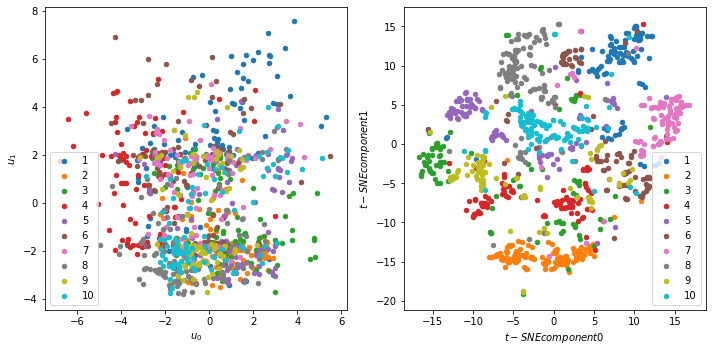

In [7]:
fig = plt.figure(figsize=(10,5))

ax = plt.subplot(1,2,1)
for i in range(10):
    plt.scatter(u[y==i][:,0], u[y==i][:,1], c="C{}".format(i), s=20., label="{}".format(i+1))
plt.legend()
plt.xlabel(r"$u_0$")
plt.ylabel(r"$u_1$")
    
ax = plt.subplot(1,2,2)
for i in range(10):
    plt.scatter(tsne[y==i][:,0], tsne[y==i][:,1], c="C{}".format(i), s=20., label="{}".format(i+1))
plt.legend()
plt.xlabel(r"$t-SNE component 0$")
plt.ylabel(r"$t-SNE component 1$")

plt.tight_layout()
plt.savefig("../figures/mnist_latent.pdf")


## Visualize reconstruction

In [8]:
x = torch.cat([mnist[i][0] for i in range(1000)], dim=0)
x = x.view(x.size(0), -1)
y = np.asarray([mnist[i][1] for i in range(1000)])

In [9]:
x.size()

torch.Size([1000, 784])

In [10]:
h = ae.encode(x)
x_out = ae.decode(h)

In [11]:
h = h.detach().numpy()
x = x.detach().numpy()
x_out = x_out.detach().numpy()

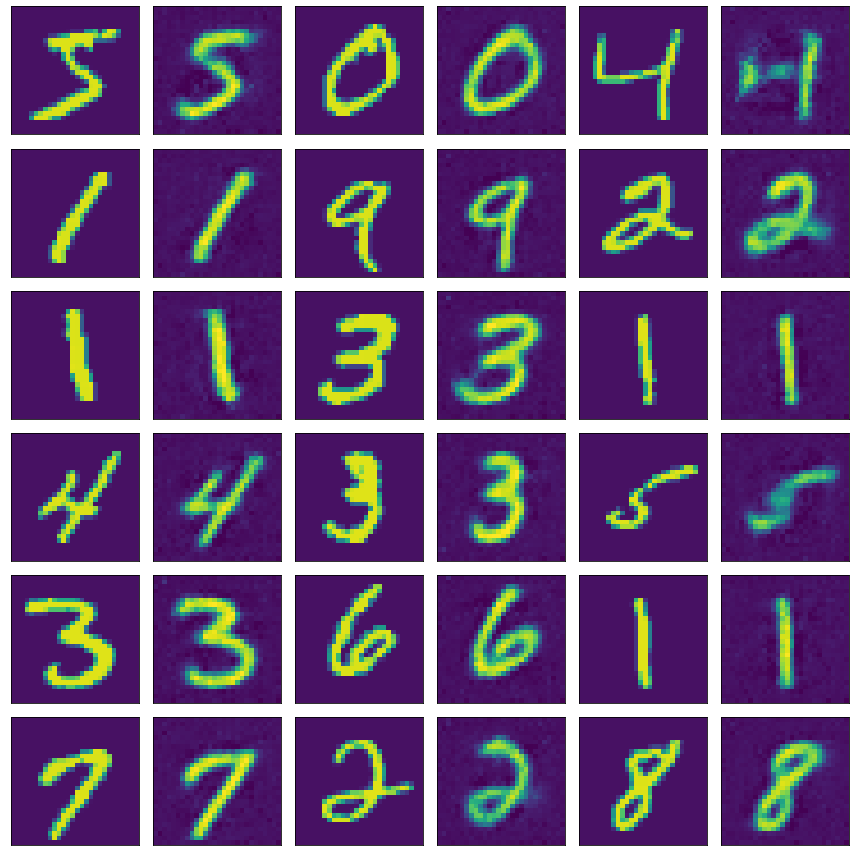

In [12]:
fig = plt.figure(figsize=(12,12))

for i in range(18):
    ax = plt.subplot(6, 6, 2*i + 1)
    plt.imshow(x[i].reshape((28,28)), vmin=-1.1, vmax=1.1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(6, 6, 2*i + 2)
    plt.imshow(x_out[i].reshape((28,28)), vmin=-1.1, vmax=1.1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
        
plt.tight_layout()
plt.savefig("../figures/reconstruction.pdf")
